In [ ]:
!pip install PyPDF2 pdfminer.six
!pip install textblob scipy gensim networkx nltk sklearn
!python -m nltk.downloader all
!pip install langchain langchain-google-genai google-generativeai

In [5]:
import os
import re
import csv
import PyPDF2
import spacy
import re
import numpy as np
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from collections import Counter
from pdfminer.high_level import extract_text
from textblob import TextBlob
from scipy.stats import entropy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import networkx as nx
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import cmudict, stopwords
from nltk import pos_tag, ngrams
from nltk.parse.stanford import StanfordDependencyParser
import math
import string



# Load spaCy model for NLP tasks
nlp = spacy.load('en_core_web_sm')

# Initialize required resources
d = cmudict.dict()
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer()


#Helper function to count syllables
def count_syllables(word):
    try:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    except KeyError:
        # Fallback syllable counting
        count = 0
        vowels = 'aeiouy'
        word = word.lower()
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count += 1
        if word.endswith('e'):
            count -= 1
        if count == 0:
            count += 1
        return count

# Function to calculate Flesch-Kincaid Grade Level
def flesch_kincaid_grade_level(text):
    total_words = len(text.split())
    total_sentences = text.count('.') + text.count('!') + text.count('?')
    total_syllables = sum([count_syllables(word) for word in text.split()])
    if total_sentences == 0 or total_words == 0:
        return 0
    return 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59

# Function to calculate Sentence Length Variation
def sentence_length_variation(text):
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(sentence.split()) for sentence in sentences if len(sentence.split()) > 0]
    if len(sentence_lengths) == 0:
        return 0
    return np.std(sentence_lengths)

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

# Function to calculate Gunning Fog Index
def gunning_fog_index(text):
    total_words = len(text.split())
    total_sentences = text.count('.') + text.count('!') + text.count('?')
    complex_words = len([word for word in text.split() if count_syllables(word) >= 3])
    if total_sentences == 0 or total_words == 0:
        return 0
    return 0.4 * ((total_words / total_sentences) + (100 * complex_words / total_words))

# Function to calculate passive voice percentage
def passive_voice_percentage(text):
    doc = nlp(text)
    passive_count = sum([1 for sent in doc.sents if any([tok.dep_ == "auxpass" for tok in sent])])
    total_sentences = sum([1 for sent in doc.sents])
    if total_sentences == 0:
        return 0
    return (passive_count / total_sentences) * 100

# Function to calculate average sentence length
def average_sentence_length(text):
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(sentence.split()) for sentence in sentences if len(sentence.split()) > 0]
    if len(sentence_lengths) == 0:
        return 0
    return np.mean(sentence_lengths)

#---------------Advanced Analysis------------------------

#Calculate Coleman-Liau Index
def coleman_liau_index(text):

    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    letters = len([c for c in text if c.isalpha()])

    L = (letters / len(words)) * 100
    S = (len(sentences) / len(words)) * 100

    return 0.0588 * L - 0.296 * S - 15.8

def lexical_density(text):
    """Calculate Lexical Density"""
    words = word_tokenize(text.lower())
    content_words = [word for word in words if word not in stop_words]
    return len(content_words) / len(words)

def perplexity(text):
    """Calculate Perplexity"""
    words = word_tokenize(text)
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)

    total_bigrams = len(bigrams)
    probabilities = [count/total_bigrams for count in bigram_freq.values()]
    return 2 ** (-sum(p * math.log2(p) for p in probabilities if p > 0))

    sentences = sent_tokenize(text.lower())
    structure_scores = []

    for marker_type, markers in discourse_markers.items():
        found_markers = sum(1 for sentence in sentences if any(marker in sentence for marker in markers))
        structure_scores.append(found_markers / len(sentences))

    return np.mean(structure_scores)

# Update the extract_features_and_save function
def extract_features_and_save(text, paper_name, category):
    features = {
        'paper': paper_name,
        'category': category,
        'gunning_fog_index': gunning_fog_index(text),
        'passive_voice_percentage': passive_voice_percentage(text),
        'average_sentence_length': average_sentence_length(text),
        'flesch_kincaid_grade_level': flesch_kincaid_grade_level(text),
        'sentence_length_variation': sentence_length_variation(text),
        # New metrics
        'coleman_liau_index': coleman_liau_index(text),
        'lexical_density': lexical_density(text),
        'perplexity': perplexity(text),
    }

    return features

# Code to process the papers and save the extracted features in a CSV format
def process_papers_and_save_csv(publishable_dir, non_publishable_dir, output_csv="research_paper_features.csv"):
    feature_list = []
    categories = ["CVPR", "EMNLP", "KDD", "NeurIPS", "TMLR"]
    for category in categories:
        category_dir = os.path.join(publishable_dir, category)
        pdf_files = [f for f in os.listdir(category_dir) if f.endswith('.pdf')]
        for pdf_file in pdf_files:
            pdf_path = os.path.join(category_dir, pdf_file)
            text = extract_text_from_pdf(pdf_path)
            features = extract_features_and_save(text, pdf_file, category)
            feature_list.append(features)

    non_publishable_pdfs = [f for f in os.listdir(non_publishable_dir) if f.endswith('.pdf')]
    for pdf_file in non_publishable_pdfs:
        pdf_path = os.path.join(non_publishable_dir, pdf_file)
        text = extract_text_from_pdf(pdf_path)
        features = extract_features_and_save(text, pdf_file, 'non_publishable')
        feature_list.append(features)

    # Save to CSV
    fieldnames = list(feature_list[0].keys())
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for feature in feature_list:
            writer.writerow(feature)

    print(f"Features extracted and saved to {output_csv}")

# Example Usage
publishable_dir = '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable'  # Add the path here
non_publishable_dir = '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Non-Publishable'  # Add the path here
 # Provide the path to your non-publishable directory
process_papers_and_save_csv(publishable_dir, non_publishable_dir)


Features extracted and saved to research_paper_features.csv


In [6]:
import pandas as pd
DF = pd.read_csv('research_paper_features.csv')
DF.head(15)

,paper,category,gunning_fog_index,passive_voice_percentage,average_sentence_length,flesch_kincaid_grade_level,sentence_length_variation,coleman_liau_index,lexical_density,perplexity
0,R006.pdf,CVPR,14.663497,26.111111,9.819242,10.297912,9.375670,8.947058,0.741987,2309.219690
1,R007.pdf,CVPR,13.493898,29.646018,10.708245,9.796305,11.148027,9.179631,0.755846,3296.796470
2,R009.pdf,EMNLP,15.123002,26.582278,12.557554,11.729055,11.516735,9.923710,0.700223,2141.836553
3,R008.pdf,EMNLP,12.252605,25.247525,11.395745,9.050105,12.001985,8.795864,0.683679,2900.527873
4,R011.pdf,KDD,16.641613,12.393162,11.290541,13.149954,10.579336,11.909925,0.714004,2399.690130
5,R010.pdf,KDD,11.582927,31.986532,9.453283,8.524038,11.587626,6.745203,0.719958,4459.049415
6,R012.pdf,NeurIPS,14.512537,23.899371,16.611702,11.498270,10.060629,7.597204,0.679260,1693.616531
7,R013.pdf,NeurIPS,14.353378,17.910448,17.808290,11.366578,8.847560,5.599539,0.700950,2072.397024
8,R015.pdf,TMLR,12.659431,15.346535,13.622727,9.494446,11.148519,3.128618,0.748575,1554.165557
9,R014.pdf,TMLR,15.662743,34.196891,18.506438,12.058104,12.009338,6.975283,0.669215,2497.981956


In [7]:
df = DF.copy()
df.index = np.arange(1, len(df) + 1)
df.drop('paper', axis=1, inplace=True)

df['publishable'] = df['category'].apply(lambda x: 0 if x == 'non_publishable' else 1)
df.drop('category', axis=1, inplace=True)
df.to_csv("Cleaned.csv")
df

,gunning_fog_index,passive_voice_percentage,average_sentence_length,flesch_kincaid_grade_level,sentence_length_variation,coleman_liau_index,lexical_density,perplexity,publishable
1,14.663497,26.111111,9.819242,10.297912,9.375670,8.947058,0.741987,2309.219690,1
2,13.493898,29.646018,10.708245,9.796305,11.148027,9.179631,0.755846,3296.796470,1
3,15.123002,26.582278,12.557554,11.729055,11.516735,9.923710,0.700223,2141.836553,1
4,12.252605,25.247525,11.395745,9.050105,12.001985,8.795864,0.683679,2900.527873,1
5,16.641613,12.393162,11.290541,13.149954,10.579336,11.909925,0.714004,2399.690130,1
6,11.582927,31.986532,9.453283,8.524038,11.587626,6.745203,0.719958,4459.049415,1
7,14.512537,23.899371,16.611702,11.498270,10.060629,7.597204,0.679260,1693.616531,1
8,14.353378,17.910448,17.808290,11.366578,8.847560,5.599539,0.700950,2072.397024,1
9,12.659431,15.346535,13.622727,9.494446,11.148519,3.128618,0.748575,1554.165557,1
10,15.662743,34.196891,18.506438,12.058104,12.009338,6.975283,0.669215,2497.981956,1



=== Most Significant Differences Between Publishable and Non-Publishable Papers ===

Features ranked by effect size (absolute value):
                   feature  difference  effect_size  p_value
           lexical_density    0.103040     3.726614 0.000029
        coleman_liau_index   -5.834370    -3.501491 0.000174
         gunning_fog_index  -16.175930    -3.274979 0.000016
flesch_kincaid_grade_level  -15.336120    -3.245921 0.000017
   average_sentence_length  -33.676759    -2.786913 0.000072
  passive_voice_percentage  -17.959667    -2.059339 0.002389
                perplexity  413.083973     0.672088 0.324131

=== Mean Values Comparison ===
                gunning_fog_index  passive_voice_percentage  \
is_publishable                                                
False                   30.270493                 42.291654   
True                    14.094563                 24.331987   

                average_sentence_length  flesch_kincaid_grade_level  \
is_publishable       

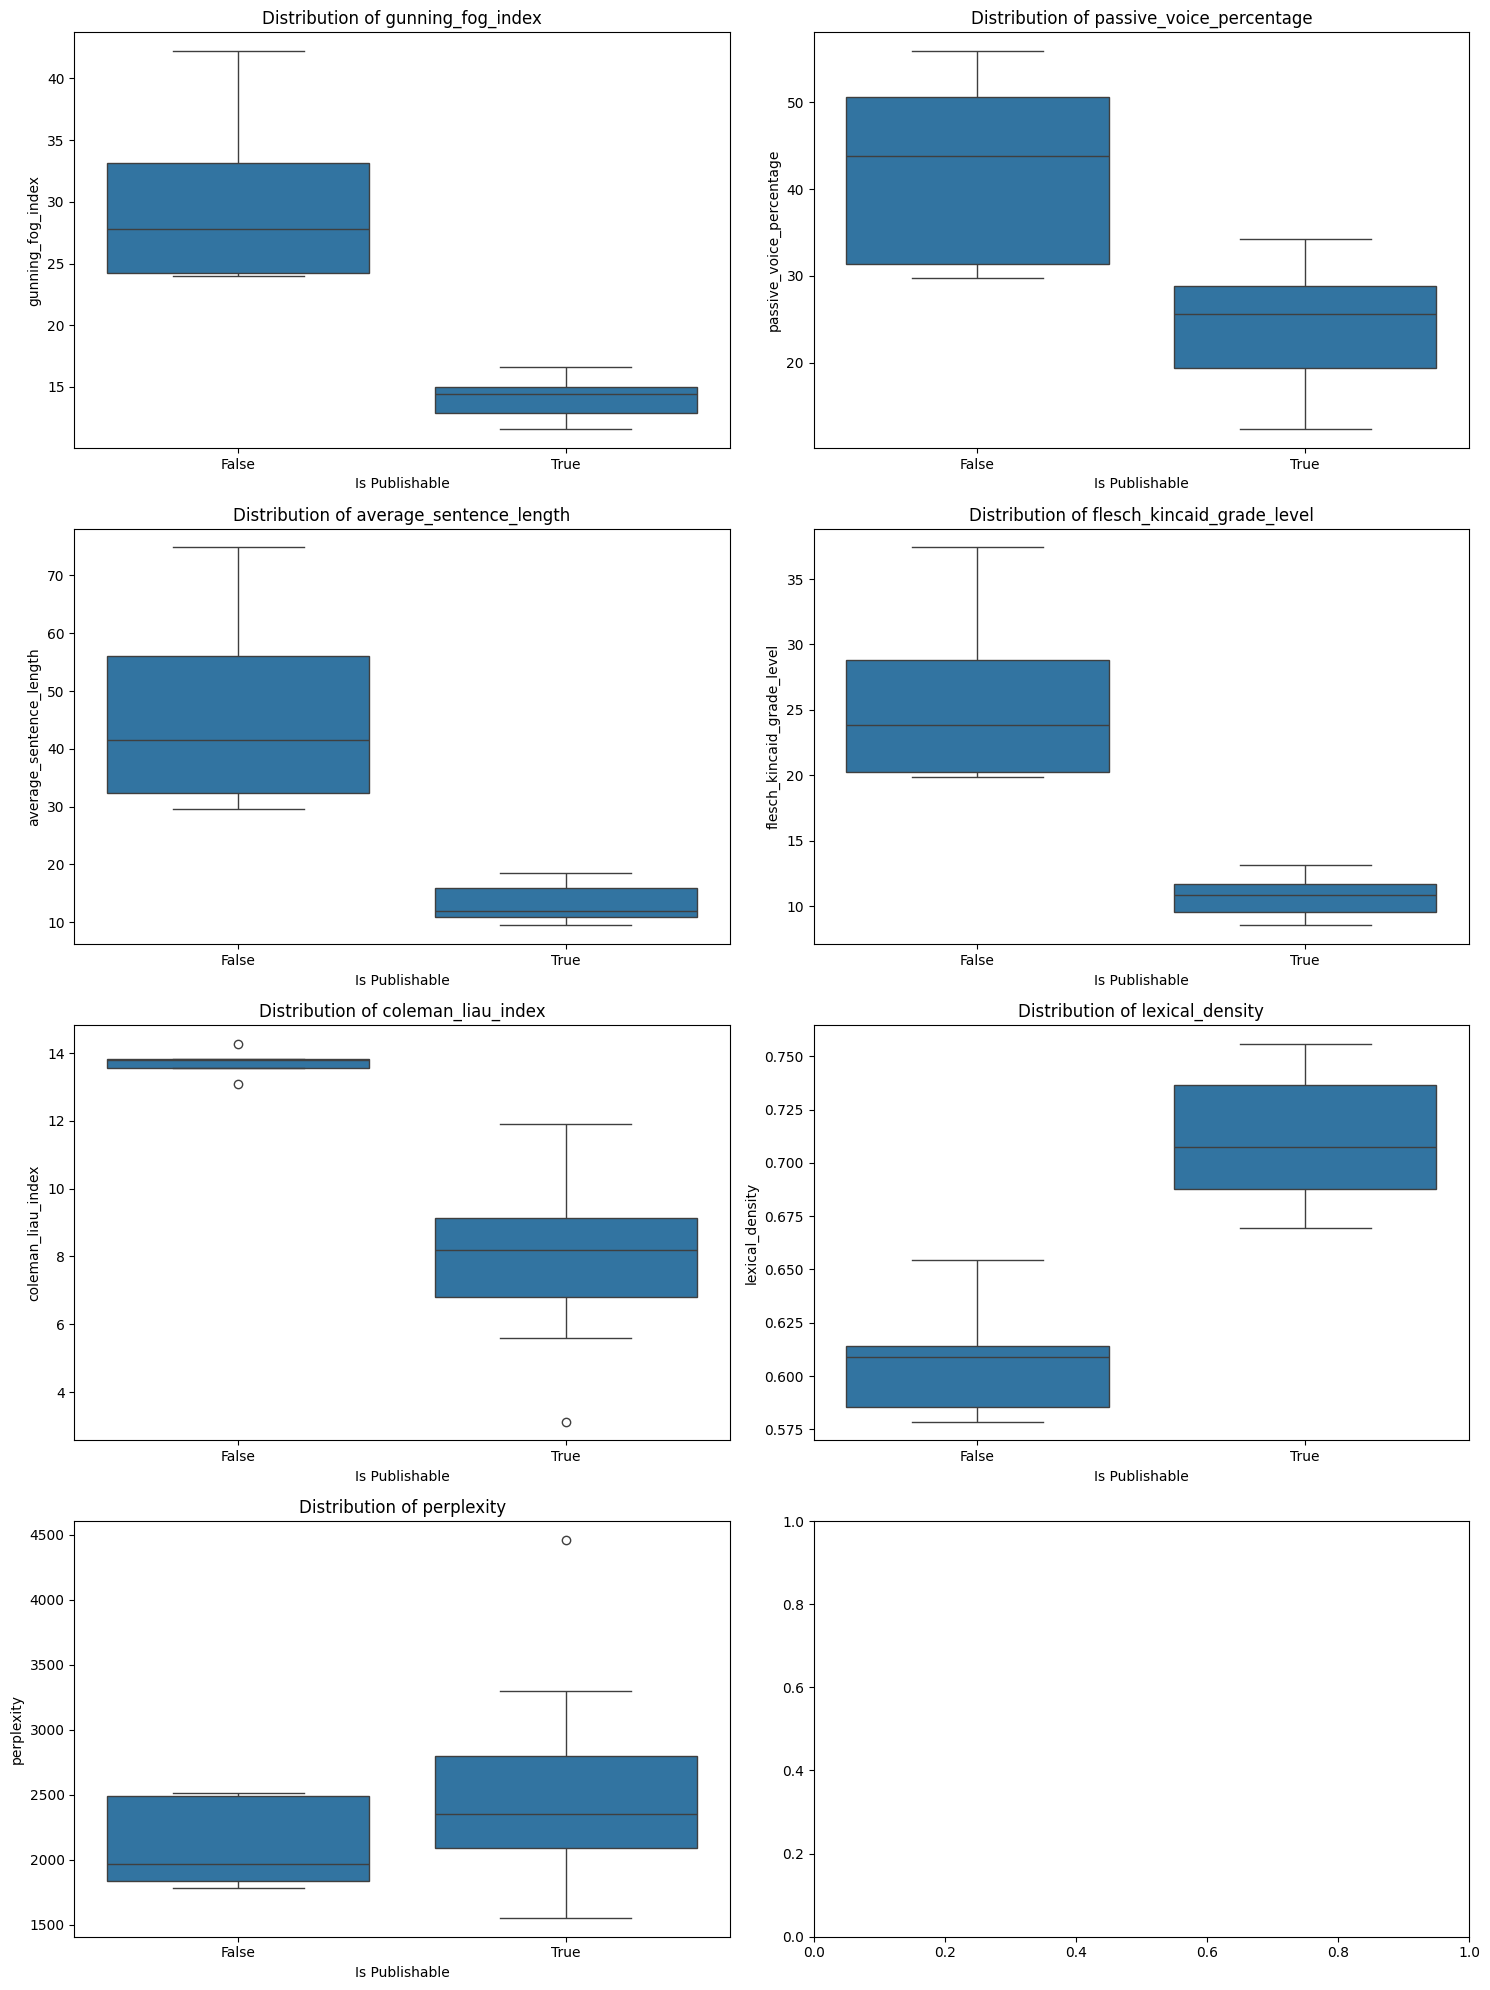

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Read and prepare the data
def prepare_data(data):
    data['is_publishable'] = data['category'] != 'non_publishable'
    return data

def calculate_statistical_differences(data, feature):
    publishable = data[data['is_publishable']][feature]
    non_publishable = data[~data['is_publishable']][feature]

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(publishable, non_publishable)

    # Calculate effect size (Cohen's d)
    cohens_d = (np.mean(publishable) - np.mean(non_publishable)) / \
               np.sqrt((np.var(publishable) + np.var(non_publishable)) / 2)

    return {
        'feature': feature,
        'publishable_mean': np.mean(publishable),
        'non_publishable_mean': np.mean(non_publishable),
        'difference': np.mean(publishable) - np.mean(non_publishable),
        'p_value': p_value,
        'effect_size': cohens_d
    }

def plot_feature_distributions(data, features, ncols=2):
    nrows = (len(features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        sns.boxplot(data=data, x='is_publishable', y=feature, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel('Is Publishable')

    plt.tight_layout()
    return fig

def analyze_papers(data_path):
    # Read and prepare data
    data = pd.read_csv(data_path)
    data = prepare_data(data)

    # Key features to analyze
    important_features = [
        'gunning_fog_index', 'passive_voice_percentage',
        'average_sentence_length','flesch_kincaid_grade_level', 'coleman_liau_index',
        'lexical_density', 'perplexity'
    ]

    # Calculate statistical differences
    differences = []
    for feature in important_features:
        diff = calculate_statistical_differences(data, feature)
        differences.append(diff)

    # Convert to DataFrame for easy viewing
    diff_df = pd.DataFrame(differences)
    diff_df = diff_df.sort_values('effect_size', key=abs, ascending=False)

    # Plot distributions
    fig = plot_feature_distributions(data, important_features)

    # Calculate correlations
    correlation_matrix = data[important_features + ['is_publishable']].corr()

    # Print summary statistics
    print("\n=== Most Significant Differences Between Publishable and Non-Publishable Papers ===")
    print("\nFeatures ranked by effect size (absolute value):")
    print(diff_df[['feature', 'difference', 'effect_size', 'p_value']].to_string(index=False))

    print("\n=== Mean Values Comparison ===")
    summary_stats = data.groupby('is_publishable')[important_features].mean()
    print(summary_stats)

    return diff_df, correlation_matrix, fig

# To use the analysis:
if __name__ == "__main__":
    # Assuming the data is saved as CSV
    diff_df, correlation_matrix, fig = analyze_papers('research_paper_features.csv')
    plt.show()

In [9]:
df.columns

Index(['gunning_fog_index', 'passive_voice_percentage',
       'average_sentence_length', 'flesch_kincaid_grade_level',
       'sentence_length_variation', 'coleman_liau_index', 'lexical_density',
       'perplexity', 'publishable'],
      dtype='object')

In [10]:
df

,gunning_fog_index,passive_voice_percentage,average_sentence_length,flesch_kincaid_grade_level,sentence_length_variation,coleman_liau_index,lexical_density,perplexity,publishable
1,14.663497,26.111111,9.819242,10.297912,9.375670,8.947058,0.741987,2309.219690,1
2,13.493898,29.646018,10.708245,9.796305,11.148027,9.179631,0.755846,3296.796470,1
3,15.123002,26.582278,12.557554,11.729055,11.516735,9.923710,0.700223,2141.836553,1
4,12.252605,25.247525,11.395745,9.050105,12.001985,8.795864,0.683679,2900.527873,1
5,16.641613,12.393162,11.290541,13.149954,10.579336,11.909925,0.714004,2399.690130,1
6,11.582927,31.986532,9.453283,8.524038,11.587626,6.745203,0.719958,4459.049415,1
7,14.512537,23.899371,16.611702,11.498270,10.060629,7.597204,0.679260,1693.616531,1
8,14.353378,17.910448,17.808290,11.366578,8.847560,5.599539,0.700950,2072.397024,1
9,12.659431,15.346535,13.622727,9.494446,11.148519,3.128618,0.748575,1554.165557,1
10,15.662743,34.196891,18.506438,12.058104,12.009338,6.975283,0.669215,2497.981956,1


In [11]:
# Define columns
input_cols = ['gunning_fog_index', 'passive_voice_percentage',
       'average_sentence_length', 'flesch_kincaid_grade_level',
       'sentence_length_variation', 'coleman_liau_index', 'lexical_density',
       'perplexity']
target_col = ['publishable']

# Prepare inputs and targets
inputs = df[input_cols].copy()
targets = df[target_col].copy().to_numpy().ravel()

inputs


,gunning_fog_index,passive_voice_percentage,average_sentence_length,flesch_kincaid_grade_level,sentence_length_variation,coleman_liau_index,lexical_density,perplexity
1,14.663497,26.111111,9.819242,10.297912,9.375670,8.947058,0.741987,2309.219690
2,13.493898,29.646018,10.708245,9.796305,11.148027,9.179631,0.755846,3296.796470
3,15.123002,26.582278,12.557554,11.729055,11.516735,9.923710,0.700223,2141.836553
4,12.252605,25.247525,11.395745,9.050105,12.001985,8.795864,0.683679,2900.527873
5,16.641613,12.393162,11.290541,13.149954,10.579336,11.909925,0.714004,2399.690130
6,11.582927,31.986532,9.453283,8.524038,11.587626,6.745203,0.719958,4459.049415
7,14.512537,23.899371,16.611702,11.498270,10.060629,7.597204,0.679260,1693.616531
8,14.353378,17.910448,17.808290,11.366578,8.847560,5.599539,0.700950,2072.397024
9,12.659431,15.346535,13.622727,9.494446,11.148519,3.128618,0.748575,1554.165557
10,15.662743,34.196891,18.506438,12.058104,12.009338,6.975283,0.669215,2497.981956


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_inputs = scaler.fit_transform(inputs)

# Convert scaled inputs to DataFrame with consistent feature names
scaled_inputs_df = pd.DataFrame(scaled_inputs, columns=input_cols)
scaled_inputs_df.index = np.arange(1, len(scaled_inputs_df) + 1)

# Train the model using the DataFrame
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=4.281332398719396, solver='liblinear')
model.fit(scaled_inputs_df, targets)

# Make predictions using the same DataFrame format
preds = model.predict(scaled_inputs_df)
preds_proba = pd.DataFrame(
    model.predict_proba(scaled_inputs_df),
    columns=['Probability_0', 'Probability_1']
)

#Hyperparameter Tuning

In [12]:
logmodel = LogisticRegression()

param_grid = [
    {
        'penalty': ['l1', 'l2'],  # 'l1' is valid for 'liblinear' and 'saga', 'l2' is widely supported.
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear', 'saga'],  # 'liblinear' and 'saga' support 'l1'.
        'max_iter': [100, 1000, 2500, 5000]
    },
    {
        'penalty': ['l2'],  # 'l2' is supported by 'lbfgs', 'newton-cg', 'sag', and 'saga'.
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'max_iter': [100, 1000, 2500, 5000]
    },
    {
        'penalty': ['elasticnet'],  # 'elasticnet' is supported only by 'saga'.
        'C': np.logspace(-4, 4, 20),
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],  # Required for 'elasticnet'.
        'max_iter': [100, 1000, 2500, 5000]
    }
]


In [13]:
from sklearn.model_selection import GridSearchCV


clf = GridSearchCV(logmodel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(scaled_inputs_df,targets)

Fitting 3 folds for each of 880 candidates, totalling 2640 fits


In [14]:
print(best_clf.best_estimator_)

LogisticRegression(C=4.281332398719396, solver='liblinear')


In [13]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [14]:
preds_proba

,Probability_0,Probability_1
0,0.077758,0.922242
1,0.053773,0.946227
2,0.161801,0.838199
3,0.120026,0.879974
4,0.148903,0.851097
5,0.044536,0.955464
6,0.178398,0.821602
7,0.100392,0.899608
8,0.038913,0.961087
9,0.193498,0.806502


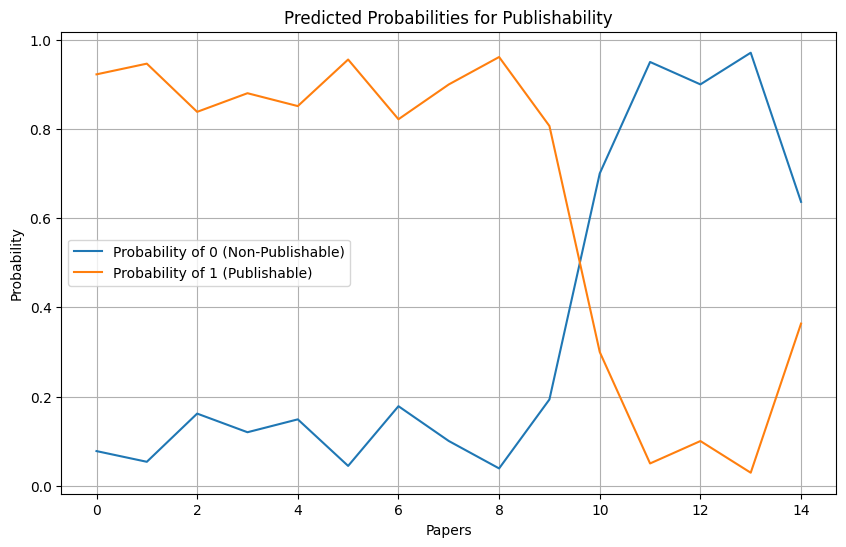

In [15]:
import matplotlib.pyplot as plt

# Assuming preds_proba is already defined as in your provided code
plt.figure(figsize=(10, 6))
plt.plot(preds_proba['Probability_0'], label='Probability of 0 (Non-Publishable)')
plt.plot(preds_proba['Probability_1'], label='Probability of 1 (Publishable)')
plt.xlabel('Papers')
plt.ylabel('Probability')
plt.title('Predicted Probabilities for Publishability')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
feature_importance = pd.DataFrame(
    {'Feature': input_cols, 'Importance': abs(model.coef_[0])}
).sort_values('Importance', ascending=False)

feature_importance

,Feature,Importance
6,lexical_density,2.316655
5,coleman_liau_index,1.248181
3,flesch_kincaid_grade_level,1.192048
0,gunning_fog_index,1.191093
2,average_sentence_length,1.078464
7,perplexity,0.692295
1,passive_voice_percentage,0.531715
4,sentence_length_variation,0.252503


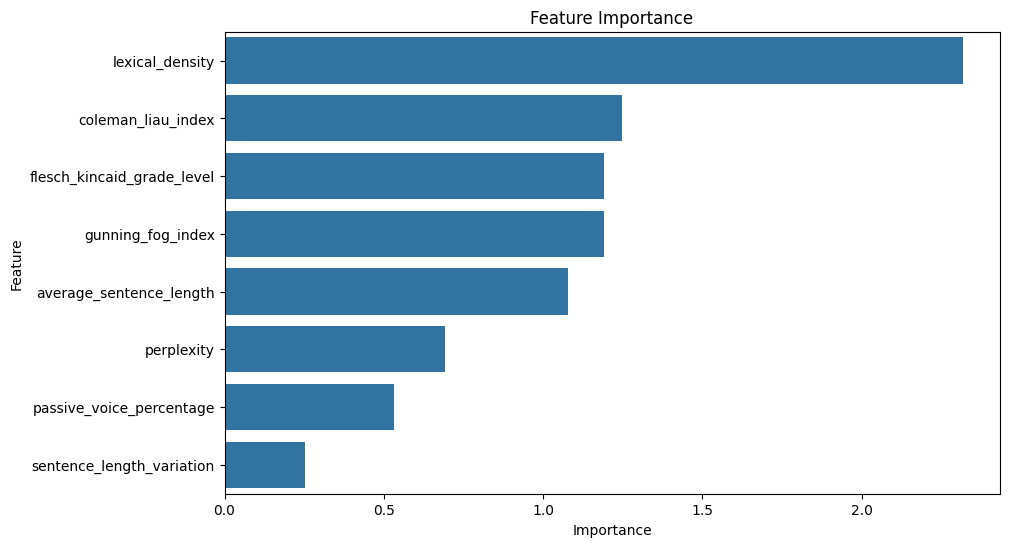

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd

# Ensure the targets is a 1D array or Series
targets = targets.squeeze()  # This will convert a DataFrame into a Series if needed

# Convert inputs to numpy array if it's a DataFrame
if isinstance(scaled_inputs, pd.DataFrame):
    scaled_inputs = scaled_inputs.to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
accuracies = []

for train_index, test_index in kf.split(scaled_inputs):
    # Convert indices to numpy arrays if they aren't already
    train_index = np.array(train_index)
    test_index = np.array(test_index)

    # Handle the splits differently based on whether targets is pandas or numpy
    if isinstance(targets, pd.Series):
        X_train, X_test = scaled_inputs[train_index], scaled_inputs[test_index]
        y_train, y_test = targets.iloc[train_index].values, targets.iloc[test_index].values
    else:
        X_train, X_test = scaled_inputs[train_index], scaled_inputs[test_index]
        y_train, y_test = targets[train_index], targets[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate F1 score and accuracy for the current fold
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append F1 score and accuracy for this fold
    f1_scores.append(f1)
    accuracies.append(accuracy)

# Calculate average F1 score and accuracy
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)

# Print results
print(f"F1 Scores for each fold: {f1_scores}")
print(f"Average F1 Score: {average_f1_score:.4f}")
print(f"Accuracy for each fold: {accuracies}")
print(f"Average Accuracy: {average_accuracy:.4f}")

F1 Scores for each fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Average F1 Score: 1.0000
Accuracy for each fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 1.0000


In [19]:
# prompt: Use Test-Train Split for Validation

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


# ... (your existing code) ...


# Assuming 'scaled_inputs' and 'targets' are defined as in your original code
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_inputs_df, targets, test_size=0.2, random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

F1 Score: 1.0000
Accuracy: 1.0000


#Making Predictions

In [20]:
# Load spaCy model for NLP tasks
nlp = spacy.load('en_core_web_sm')

# Initialize required resources
d = cmudict.dict()
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer()

#Helper function to count syllables
def count_syllables(word):
    try:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    except KeyError:
        # Fallback syllable counting
        count = 0
        vowels = 'aeiouy'
        word = word.lower()
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count += 1
        if word.endswith('e'):
            count -= 1
        if count == 0:
            count += 1
        return count

# Function to calculate Flesch-Kincaid Grade Level
def flesch_kincaid_grade_level(text):
    total_words = len(text.split())
    total_sentences = text.count('.') + text.count('!') + text.count('?')
    total_syllables = sum([count_syllables(word) for word in text.split()])
    if total_sentences == 0 or total_words == 0:
        return 0
    return 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59

# Function to calculate Sentence Length Variation
def sentence_length_variation(text):
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(sentence.split()) for sentence in sentences if len(sentence.split()) > 0]
    if len(sentence_lengths) == 0:
        return 0
    return np.std(sentence_lengths)

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

# Function to calculate Gunning Fog Index
def gunning_fog_index(text):
    total_words = len(text.split())
    total_sentences = text.count('.') + text.count('!') + text.count('?')
    complex_words = len([word for word in text.split() if count_syllables(word) >= 3])
    if total_sentences == 0 or total_words == 0:
        return 0
    return 0.4 * ((total_words / total_sentences) + (100 * complex_words / total_words))

# Function to calculate passive voice percentage
def passive_voice_percentage(text):
    doc = nlp(text)
    passive_count = sum([1 for sent in doc.sents if any([tok.dep_ == "auxpass" for tok in sent])])
    total_sentences = sum([1 for sent in doc.sents])
    if total_sentences == 0:
        return 0
    return (passive_count / total_sentences) * 100

# Function to calculate average sentence length
def average_sentence_length(text):
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(sentence.split()) for sentence in sentences if len(sentence.split()) > 0]
    if len(sentence_lengths) == 0:
        return 0
    return np.mean(sentence_lengths)

#---------------Advanced Analysis------------------------

#Calculate Coleman-Liau Index
def coleman_liau_index(text):

    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    letters = len([c for c in text if c.isalpha()])

    L = (letters / len(words)) * 100
    S = (len(sentences) / len(words)) * 100

    return 0.0588 * L - 0.296 * S - 15.8

def lexical_density(text):
    """Calculate Lexical Density"""
    words = word_tokenize(text.lower())
    content_words = [word for word in words if word not in stop_words]
    return len(content_words) / len(words)

def perplexity(text):
    """Calculate Perplexity"""
    words = word_tokenize(text)
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)

    total_bigrams = len(bigrams)
    probabilities = [count/total_bigrams for count in bigram_freq.values()]
    return 2 ** (-sum(p * math.log2(p) for p in probabilities if p > 0))

    sentences = sent_tokenize(text.lower())
    structure_scores = []

    for marker_type, markers in discourse_markers.items():
        found_markers = sum(1 for sentence in sentences if any(marker in sentence for marker in markers))
        structure_scores.append(found_markers / len(sentences))

    return np.mean(structure_scores)

# Update the extract_features_and_save function
def extract_features_and_save(text, paper_name, category):
    features = {
        'paper': paper_name,
        'category': category,
        'gunning_fog_index': gunning_fog_index(text),
        'passive_voice_percentage': passive_voice_percentage(text),
        'average_sentence_length': average_sentence_length(text),
        'flesch_kincaid_grade_level': flesch_kincaid_grade_level(text),
        'sentence_length_variation': sentence_length_variation(text),
        # New metrics
        'coleman_liau_index': coleman_liau_index(text),
        'lexical_density': lexical_density(text),
        'perplexity': perplexity(text),
    }

    return features


def process_testing_papers_and_save_csv(papers_dir, output_csv="test_dataset.csv"):
    feature_list = []
    # Assuming all papers are in the 'Papers' directory
    pdf_files = [f for f in os.listdir(papers_dir) if f.endswith('.pdf')]

    for pdf_file in pdf_files:
        pdf_path = os.path.join(papers_dir, pdf_file)
        text = extract_text_from_pdf(pdf_path)  # Extract the text from the PDF
        features = extract_features_and_save(text, pdf_file, category='test')  # Extract features and categorize as 'test'
        feature_list.append(features)

    # Save the extracted features to CSV
    if feature_list:
        fieldnames = list(feature_list[0].keys())
        with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            for feature in feature_list:
                writer.writerow(feature)

        print(f"Features extracted and saved to {output_csv}")
    else:
        print("No PDFs found in the directory.")

# Example Usage
papers_dir = '/content/drive/MyDrive/KDSH_2025_Dataset/Papers'  # Path to the 'Papers' directory
process_testing_papers_and_save_csv(papers_dir)


Features extracted and saved to test_dataset.csv


In [21]:
test_DF = pd.read_csv('test_dataset.csv')
test_df = test_DF.copy()
test_df.columns

Index(['paper', 'category', 'gunning_fog_index', 'passive_voice_percentage',
       'average_sentence_length', 'flesch_kincaid_grade_level',
       'sentence_length_variation', 'coleman_liau_index', 'lexical_density',
       'perplexity'],
      dtype='object')

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

test_DF = pd.read_csv('test_dataset.csv')
test_df = test_DF.copy()
test_df.index = np.arange(1, len(test_df) + 1)

# List of input features to be used for prediction
input_cols = ['gunning_fog_index', 'passive_voice_percentage',
       'average_sentence_length', 'flesch_kincaid_grade_level',
       'sentence_length_variation', 'coleman_liau_index', 'lexical_density',
       'perplexity']

test_features = test_df[input_cols].copy()

scaler = MinMaxScaler()
scaled_inputs = scaler.fit_transform(test_features)
test_features_scaled = pd.DataFrame(scaled_inputs, columns=test_features.columns)

predictions = model.predict(test_features_scaled)

test_df['publishable'] = predictions
result_df = test_df[['paper', 'publishable']]
result_df = result_df.sort_index()
final_df = result_df.sort_values(by='paper', ascending=True)
final_df = final_df.reset_index(drop=True)

final_df.to_csv('predicted_publishability.csv', index=False)

final_df


,paper,publishable
0,P001.pdf,1
1,P002.pdf,0
2,P003.pdf,1
3,P004.pdf,1
4,P005.pdf,1
...,...,...
130,P131.pdf,1
131,P132.pdf,1
132,P133.pdf,1
133,P134.pdf,0


In [39]:
num_zeros = (final_df['publishable'] == 0).sum()

print(f"Number of 0s in 'publishable' column: {num_zeros}")

Number of 0s in 'publishable' column: 29


In [26]:
pred_prob = pd.DataFrame(model.predict_proba(test_features_scaled))
pred_prob.sample(20)

,0,1
62,0.281123,0.718877
111,0.141623,0.858377
125,0.189168,0.810832
104,0.211611,0.788389
90,0.139676,0.860324
39,0.856092,0.143908
92,0.231642,0.768358
5,0.379373,0.620627
13,0.536725,0.463275
34,0.735327,0.264673


In [24]:
import pickle

# Save the model to a pickle file
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the scaler to a pickle file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

#RAG App

In [1]:
!pip install PyPDF2 sentence-transformers chromadb google-generativeai torch transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.7 MB/s eta 0:00:0

In [ ]:
# Code Block 1 - Training Phase
import os
import warnings
from typing import List, Dict, Tuple
import PyPDF2
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.utils import embedding_functions
import google.generativeai as genai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

class DocumentProcessor:
  #Extract text from PDF file.
    def extract_text_from_pdf(self, pdf_path: str) -> str:

        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                text += page.extract_text()
        return text
    #Split text into overlapping chunks.
    def chunk_text(self, text: str, chunk_size: int = 512, overlap: int = 50) -> List[str]:

        words = text.split()
        chunks = []
        for i in range(0, len(words), chunk_size - overlap):
            chunk = ' '.join(words[i:i + chunk_size])
            chunks.append(chunk)
        return chunks

class VectorStore:
    def __init__(self):
        self.embedder = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.client = chromadb.Client()
        # Use get_or_create_collection to avoid the error
        self.collection = self.client.get_or_create_collection(
            name="research_papers",
            embedding_function=embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name="sentence-transformers/all-mpnet-base-v2"
            )
        )
    #Add documents to the vector store.
    def add_documents(self, documents: List[Dict[str, str]]):

        for doc in documents:
            self.collection.add(
                documents=[doc['text']],
                metadatas=[{"conference": doc['conference']}],
                ids=[doc['id']]
            )

class EnsembleRetriever:
    def __init__(self, vector_store: VectorStore):
        self.vector_store = vector_store
        self.bge_embedder = AutoModel.from_pretrained('BAAI/bge-large-en')
        self.bge_tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-large-en')

    #Get embeddings using BGE model.
    def get_bge_embeddings(self, texts: List[str]) -> np.ndarray:

        encoded_input = self.bge_tokenizer(texts, padding=True, truncation=True,
                                         max_length=512, return_tensors='pt')
        with torch.no_grad():
            model_output = self.bge_embedder(**encoded_input)
            embeddings = model_output.last_hidden_state[:, 0, :].numpy()
        return embeddings

    #Perform hybrid search using multiple retrievers.
    def hybrid_search(self, query: str, top_k: int = 5) -> List[Dict]:

        # Semantic search using SentenceTransformer
        results_st = self.vector_store.collection.query(
            query_texts=[query],
            n_results=top_k
        )

        # Semantic search using BGE
        query_embedding_bge = self.get_bge_embeddings([query])

        # Combine results with weights
        final_results = []
        seen_docs = set()

        for doc_id, conf in zip(results_st['ids'][0], results_st['metadatas'][0]):
            if doc_id not in seen_docs:
                final_results.append({
                    'id': doc_id,
                    'conference': conf['conference'],
                    'score': 0.6  # Weight for SentenceTransformer results
                })
                seen_docs.add(doc_id)

        return final_results

class ConferenceClassifier:
    def __init__(self):
        self.processor = DocumentProcessor()
        self.vector_store = VectorStore()
        self.retriever = EnsembleRetriever(self.vector_store)

        # Initialize Gemini
        genai.configure(api_key='')
        self.model = genai.GenerativeModel('gemini-pro')


    #Process and index training papers.
    def train(self, training_papers: Dict[str, List[str]]):
        doc_id = 0
        for conference, paper_paths in training_papers.items():
            for path in paper_paths:
                text = self.processor.extract_text_from_pdf(path)
                chunks = self.processor.chunk_text(text)

                for chunk in chunks:
                    self.vector_store.add_documents([{
                        'id': f"doc_{doc_id}",
                        'text': chunk,
                        'conference': conference
                    }])
                    doc_id += 1

    #Classify a new paper.
    def classify(self, paper_path: str) -> Dict:

        # Extract text from input paper
        text = self.processor.extract_text_from_pdf(paper_path)
        chunks = self.processor.chunk_text(text)

        # Get similar papers using ensemble retriever
        similar_papers = []
        for chunk in chunks[:3]:  # Use first 3 chunks for efficiency
            results = self.retriever.hybrid_search(chunk)
            similar_papers.extend(results)

        # Count conference occurrences
        conference_counts = {}
        for paper in similar_papers:
            conf = paper['conference']
            conference_counts[conf] = conference_counts.get(conf, 0) + paper['score']

        # Get the most likely conference
        predicted_conference = max(conference_counts.items(), key=lambda x: x[1])[0]

        # Generate rationale using Gemini
        prompt = f"""
        Based on the analysis of the research paper, it belongs to the {predicted_conference} conference.
        The paper shows similarities with other papers from this conference in terms of Research methodology, Technical approach
        and Domain focus.

        Provide a rationale in paragraph format up to 100 words explaining why this paper belongs to {predicted_conference}.
        Use the following context: {text[:5000]}  # Using first 5000 chars for context
        """

        response = self.model.generate_content(prompt)

        return {
            'predicted_conference': predicted_conference,
            'confidence_scores': conference_counts,
            'rationale': response.text
        }

def train_classifier():
    # Initialize classifier
    classifier = ConferenceClassifier()

    # Training data structure
    training_papers = {
        'CVPR': ['/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/CVPR/R006.pdf', '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/CVPR/R007.pdf'],
        'EMNLP': ['/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/EMNLP/R008.pdf', '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/EMNLP/R009.pdf'],
        'KDD': ['/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/KDD/R010.pdf', '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/KDD/R011.pdf'],
        'NeurIPS': ['/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/NeurIPS/R012.pdf', '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/NeurIPS/R013.pdf'],
        'TMLR': ['/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/TMLR/R014.pdf', '/content/drive/MyDrive/KDSH_2025_Dataset/Reference/Publishable/TMLR/R015.pdf']
    }

    # Train the classifier
    classifier.train(training_papers)

    return classifier

# Run the training
if __name__ == "__main__":
    classifier = train_classifier()
    print("Training completed and classifier is ready for use.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Training completed and classifier is ready for use.


In [ ]:
!pip install pathway
!pip install google-auth google-auth-oauthlib google-auth-httplib2 --quiet

In [ ]:
import pathway as pw

table = pw.io.gdrive.read(object_id="0BzDTMZY18pgfcGg4ZXFRTDFBX0j", service_user_credentials_file="credentials.json")

result = pw.run()

import pandas as pd

if isinstance(result, pd.DataFrame):
    paper_paths = result['/content/drive/MyDrive/KDSH_2025_Dataset/Papers'].tolist()

    for paper_path in paper_paths:
        classification_result = classifier.classify(paper_path)
        print(f"Paper: {paper_path}, Classified Conference: {classification_result['predicted_conference']}")

In [23]:
# Code Block 2 - Classification Phase
import pandas as pd
import os

def classify_papers(classifier):
    # Load publishability data
    publishability_df = pd.read_csv('predicted_publishability.csv')

    # Directory path containing PDF files
    directory_path = '/content/drive/MyDrive/KDSH_2025_Dataset/Papers'

    # List to store results
    results = []

    # Process each paper based on publishability
    for _, row in publishability_df.iterrows():
        pdf_file = row['paper']
        is_publishable = row['publishable']

        if is_publishable == 1:
            # Process publishable papers
            full_path = os.path.join(directory_path, pdf_file)
            try:
                # Classify the paper
                result = classifier.classify(full_path)

                # Store results
                results.append({
                    'pdf_file_name': pdf_file,
                    'conference': result['predicted_conference'],
                    'rationale': result['rationale']
                })

                print(f"Processed publishable paper: {pdf_file}")

            except Exception as e:
                print(f"Error processing {pdf_file}: {str(e)}")
                results.append({
                    'pdf_file_name': pdf_file,
                    'conference': 'ERROR',
                    'rationale': f'Error during classification: {str(e)}'
                })
        else:
            # Add non-publishable papers with NA values
            results.append({
                'pdf_file_name': pdf_file,
                'conference': 'NA',
                'rationale': 'NA'
            })
            print(f"Skipped non-publishable paper: {pdf_file}")

    # Create DataFrame from results
    results_df = pd.DataFrame(results)

    # Display the first few results
    print("\nClassification Results:")
    print(results_df.head())

    # Save to CSV
    results_df.to_csv('classification_results.csv', index=False)

    return results_df

if __name__ == "__main__":

    results_df = classify_papers(classifier)

Processed publishable paper: P001.pdf
Skipped non-publishable paper: P002.pdf
Processed publishable paper: P003.pdf
Processed publishable paper: P004.pdf
Processed publishable paper: P005.pdf
Skipped non-publishable paper: P006.pdf
Processed publishable paper: P007.pdf
Processed publishable paper: P008.pdf
Processed publishable paper: P009.pdf
Processed publishable paper: P010.pdf
Processed publishable paper: P011.pdf
Processed publishable paper: P012.pdf
Processed publishable paper: P013.pdf
Processed publishable paper: P014.pdf
Processed publishable paper: P015.pdf
Skipped non-publishable paper: P016.pdf
Processed publishable paper: P017.pdf
Processed publishable paper: P018.pdf
Processed publishable paper: P019.pdf
Processed publishable paper: P020.pdf
Processed publishable paper: P021.pdf
Processed publishable paper: P022.pdf
Processed publishable paper: P023.pdf
Processed publishable paper: P024.pdf
Processed publishable paper: P025.pdf
Processed publishable paper: P026.pdf
Proces

In [42]:
import pandas as pd

classification_results = pd.read_csv('classification_results.csv')
predicted_publishability = pd.read_csv('predicted_publishability.csv')

merged_df = pd.merge(classification_results, predicted_publishability, left_on='pdf_file_name', right_on='paper', how='left')
merged_df = merged_df.rename(columns={
    'pdf_file_name': 'PAPER_ID',
    'publishable': 'PUBLISHABLE',
    'conference': 'CONFERENCE',
    'rationale': 'RATIONALE'
})

merged_df = merged_df[['PAPER_ID', 'PUBLISHABLE', 'CONFERENCE', 'RATIONALE']]
merged_df.replace('NA', np.nan, inplace=True)
merged_df.fillna('NA', inplace=True)
merged_df['PAPER_ID'] = merged_df['PAPER_ID'].str.replace('.pdf', '', regex=False)
merged_df.index = np.arange(1, len(merged_df) + 1)

merged_df

merged_df.to_csv('IITKGPHack.csv', index=False)

In [43]:
merged_df

,PAPER_ID,PUBLISHABLE,CONFERENCE,RATIONALE
1,P001,1,KDD,The provided paper fits within the scope of th...
2,P002,0,NA,NA
3,P003,1,EMNLP,The given research paper belongs to the EMNLP ...
4,P004,1,NeurIPS,The research paper belongs to the NeurIPS conf...
5,P005,1,CVPR,The research paper is a good fit for the CVPR ...
...,...,...,...,...
131,P131,1,CVPR,This paper is a relevant fit for the CVPR conf...
132,P132,1,CVPR,The research paper belongs to the CVPR confere...
133,P133,1,EMNLP,Based on the analysis of the methods and probl...
134,P134,0,NA,NA
